# ADS 504 Initial Work

In [32]:
import re

import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords


nlp = spacy.load("en_core_web_sm")



## Reading in the Data

In [2]:
data_location = "/Users/mtc/ADS/ADS 504/Project/missing_persons_clean.csv"

missing = pd.read_csv(data_location)

In [3]:
missing.head()

,name,description,long,lat,location
0,NamUs #UP4795 ME/C Case Number GC99-158 604UFMN,"date found: November 4, 1999location: Red Wing...",-92.541061,44.565821,POINT(-92.5410605 44.5658215)
1,NamUs #UP4804 ME/C Case Number 39918 849UFMN,"date found: July 20, 1977location: St. Paul, M...",-93.055401,44.941109,POINT(-93.0554009 44.9411089)
2,NamUS #UP4808 ME/C Case Number 00-1411 270UFMN,NaN,-93.194060,45.078014,POINT(-93.1940597 45.0780144)
3,NamUs #UP4796 ME/C Case Number GC07-39 102UFMN,"date found: March 26, 2007location: Treasure I...",-92.641182,44.635803,POINT(-92.6411819 44.6358033)
4,NamUs #UP6525 ME/C Case Number FC08-61 803UFMN,"date found: August 10, 2008location: Mabel, Mi...",-91.773434,43.520049,POINT(-91.7734337 43.5200495)


## Splitting the description column

In [4]:
start = '^.*'
end = '.*'

col1 = 'location'
col2 = 'age est'
col3 = 'race'
col4 = 'height'
col5 = 'weight'
col6 = 'description'

In [5]:
date = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(col1+end, '', str(description))
    data_clean = re.sub('date found: ', '', info)
    date.append(data_clean)
date = pd.DataFrame(date)

location = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col1, '', str(re.sub(col2+end, '', str(description))))
    data_clean = re.sub('location: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    location.append(data_clean2)  
location = pd.DataFrame(location)

age_est = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col2, '', str(re.sub(col3+end, '', str(description))))
    data_clean = re.sub('age est.:', '', info)
    data_clean2 = re.sub('.:', '', data_clean)
    age_est.append(data_clean2)  
age_est = pd.DataFrame(age_est)

race= []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col3, '', str(re.sub(col4+end, '', str(description))))
    data_clean = re.sub('race: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    race.append(data_clean2)  
race = pd.DataFrame(race)

height = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col4, '', str(re.sub(col5+end, '', str(description))))
    data_clean = re.sub('height: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    height.append(data_clean2)  
height = pd.DataFrame(height)

weight = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col5, '', str(re.sub(col6+end, '', str(description))))
    data_clean = re.sub('weight: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    weight.append(data_clean2)  
weight = pd.DataFrame(weight)

desc = []
for row in range(len(missing)):
    description = missing['description'][row]
    info = re.sub(start+col6, '', str(description))
    data_clean = re.sub('description: ', '', info)
    data_clean2 = re.sub(':', '', data_clean)
    desc.append(data_clean2)  

description = pd.DataFrame(desc)

## Creating the preliminary dataset

In [6]:
cleaned = pd.DataFrame()

cleaned['index_v'] = missing.index
cleaned['name'] = missing['name']
cleaned['date'] = date
cleaned['location'] = location
cleaned['age_est'] = age_est
cleaned['race'] = race
cleaned['height'] = height
cleaned['weight'] = weight
cleaned['description'] = description
cleaned['long'] = missing['long']
cleaned['lat'] = missing['lat']


In [7]:
missing_str = ['', ' ', 'nan']
               
for item in missing_str:
    cleaned = cleaned.replace(item, np.nan)

## Updating the date column 

In [8]:
date = []
for index in cleaned.index:
    orig = str(cleaned['date'][index])
    char = len(orig)
    if char < 30:
        date.append({'index_v': index, 'date_pull': orig})
    else:
        date_pull = re.search('((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})',str(cleaned['description'][index]))
        date_pull2 = re.search('((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})',str(cleaned['name'][index]))
        date_pull3 = re.search('((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})',str(cleaned['date'][index]))
        if date_pull:
            date_pull = date_pull.group()
            date.append({'index_v': index, 'date_pull':date_pull})
        elif date_pull2:
            date_pull2 = date_pull2.group()
            date.append({'index_v': index, 'date_pull': date_pull2})
        elif date_pull3:
            date_pull3 = date_pull3.group()
            date.append({'index_v': index, 'date_pull': date_pull3})
        else:
            date.append({'index_v': index, 'date_pull': "no match found"})

dates = pd.DataFrame(date)
dates[dates['date_pull']=='nan'] = np.nan

# replace date column in original df with dates 
for row in range(len(cleaned)):
    cleaned.loc[row, 'date'] = dates['date_pull'][row]

## Updating the age column

In [9]:

ages=[]

for row in range(len(cleaned)):
    item = str(cleaned['age_est'][row])
    text = re.search(r'(month)|(Adult)|(newborn)|(fetus)', item)
    orig = re.search(r'(\d{1,2} - \d{1,2})|(\d{1,2}-\d{1,2})', item)
    age_pull = re.search(r'(\d{1,2} to \d{1,2})|(\d{1,2}-\d{1,2} year)', str(cleaned['name'][row]))
    age_pull2 = re.search(r'age \d{1,2}',str(cleaned['date'][row]))

    if text:
        ages.append({'index_v': row, 'age_low':item, 'age_high': item})

    elif orig:
        age = re.findall(r'\d{1,2}', item)
        ages.append({'index_v': row, 'age_low': age[0], 'age_high': age[1]})
    
    elif age_pull:
        age = re.findall(r'\d{1,2}', str(cleaned['name'][row]))
        ages.append({'index_v': row, 'age_low': age[0], 'age_high': age[1]})

    elif age_pull2:
        age = re.findall(r'\d{1,2}', str(cleaned['date'][row]))
        ages.append({'index_v': row, 'age_low': age, 'age_high':age})
    
    else:
        ages.append({'index_v': row, 'age_low': np.nan, 'age_high': np.nan})


ages = pd.DataFrame(ages)

# replace date column in original df with dates 
for row in range(len(cleaned)):
    cleaned.loc[row, 'age_low'] = ages['age_low'][row]
    cleaned.loc[row, 'age_high'] = ages['age_high'][row]

cleaned = cleaned.drop('age_est', axis = 1)

## Updating the race column

In [10]:
races = []

for item in range(len(cleaned['race'].unique())):
    race = str(cleaned['race'].unique()[item])
    split = race.split("','")
    for a in split:
        a = str(a)
        split2 = a.split(",")
        for b in split2:
            b = str(b)
            c = re.sub("'", '', b)
            races.append(c)

r = pd.DataFrame(races)
r.columns = ['race']


list = "'"
start = "("
end = ")|"

for item in range(len(r['race'].unique())):
    race = str(r['race'].unique()[item])
    race = race[1:]
    reg =  start+race+end
    list += reg
list+= '"'

races=[]

for index in cleaned['name'].index:
    orig = re.search(r'.*',str(cleaned['race'][index]))
    race = re.search(list,str(cleaned['name'][index]))
    if orig:
        race_pull = str(cleaned['race'][index])
        races.append({'index_v':index, 'race_pull':race_pull})
    elif race:
        race_pull = race.group()
        races.append({'index_v': index, 'race_pull':race})
    else:
        races.append({'index_v': index, 'race_pull': "no match found"})

races = pd.DataFrame(races)

# replace race column in original df with races 
for row in range(len(cleaned)):
    cleaned.loc[row, 'race'] = races['race_pull'][row]

## Cleaning the height column and converting everything to inches

In [11]:
heights = []

for row in range(len(cleaned)):
    item = str(cleaned['height'][row])
    item = item[:5]
    heights.append(item)


height2 = []

for item in heights:
    height = re.sub("'", " feet ", item)
    height = re.sub('"', "", height)
    height = re.sub('^ ', '', height)
    height2.append(height)

h = []
for item in height2:
    is_ft = re.search(r'(feet)', item)
    if is_ft:
        item = item + ' inches'
        feet = int(item[:1])
        inch = item[7:]
        inch = int(item[:1])
        total = (feet*12) + inch    
    else:
        height = re.search(r'\d{2,3}', item)
        if height:
            cm = height.group(0)
            total = int(cm) * 0.393701
        else:
            total = np.nan
    
    h.append({'height_in': total})


height_df = pd.DataFrame(h)

for row in range(len(cleaned)):
    cleaned.loc[row, 'height'] = height_df['height_in'][row]



## Cleaning the weight column

In [12]:
weight_n = []

for index in cleaned.index:
    weight = re.sub(r'lbs.*', '', str(cleaned['weight'][index]))
    is_n = re.search(r'\d{1,3}', weight)

    if is_n:
        total = int(re.findall(r'\d{1,3}', weight)[0])
    else:
        total = np.nan

    weight_n.append({'weight_n': total})

weight_n = pd.DataFrame(weight_n)

for row in range(len(cleaned)):
    cleaned.loc[row, 'weight'] = weight_n['weight_n'][row]


## Cleaning the location column

In [13]:
for row in range(len(cleaned)):
    cleaned.loc[row, 'location'] = re.sub(r'age.*', '', str(cleaned['location'][row]))

In [14]:
for row in range(len(cleaned)):
    date = r'((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})'
    url = r'http.*(informationlinks|html|pdflinks|\d{4,5}|nav)'
    unknown = r'[^\x00-\x7F]+'
    link_str = r'\s{0,1}links\s{0,1}'
    exact = r'(\(exact location not given\)|\(exact coordinates\)|\(exact location in county not given\))'

    string = re.sub(date, '', str(cleaned['description'][row]))
    string = re.sub(url, '', string)
    string = re.sub(unknown, '', string)
    string = re.sub(r'^(\s|\.)$', '', string)
    string = re.sub(exact, '', string)

    cleaned.loc[row, 'description'] = re.sub(link_str, '', string)

## Looking at the distribution of missing data

In [15]:
cleaned = cleaned.replace('nan', np.nan)
cleaned = cleaned.replace('no match found', np.nan)

cleaned.isnull().sum()

index_v            0
name               0
date            9347
location        8844
race           11928
height         12162
weight         13438
description     2504
long               0
lat                0
age_low        13761
age_high       13761
dtype: int64

In [16]:
cleaned[['name', 'date', 'location', 'race', 'age_low', 'age_high', 'description','long','lat']].isnull().sum()

name               0
date            9347
location        8844
race           11928
age_low        13761
age_high       13761
description     2504
long               0
lat                0
dtype: int64

In [17]:
no_na = cleaned[['name', 'date', 'location', 'race', 'age_low', 'age_high', 'description','long','lat']].dropna()
no_na = no_na[~(no_na['description']== '')]
no_na = no_na[~(no_na['date']== '1983')]

In [18]:
for index in no_na.index:
    age_low = str(no_na['age_low'][index])
    age_high = str(no_na['age_high'][index])
    is_ch = re.search(r'[^\d]', age_high)
    if is_ch:
        value = age_high
        is_inf = re.search(r'month', value)
        is_f = re.search(r'newborn|fetus', value)
        is_adult_pre = re.search(r'(A|a)dult.{1,3}(P|p)re', value)
        is_range = re.search(r'\d{2}-\d{2}', value)
        is_adult = re.search(r'^ Adult$', value)
        is_lt_ya = re.search(r'Teen - Young', value)
        if is_inf:
            age_low = 0
            age_high = 1
        elif is_f:
            age_low = 0
            age_high = 0
        elif is_adult_pre:
            high = int(re.search(r'\d{2}', value).group())
            age_low = 18
            age_high = high
        elif is_range:
            age = re.findall(r'\d{2}', value)
            age_low = int(age[0])
            age_high=int(age[0])
        elif is_adult:
            age_low = 18
            age_high = 90
        elif is_lt_ya:
            age_low = 17
            age_high = 23
        else:
            age_low = 'no age found'
            age_high = 'no age found'
    else:
        age_low = no_na['age_low'][index]
        age_high = no_na['age_high'][index]

    no_na.loc[index, 'age_low'] = age_low
    no_na.loc[index, 'age_high'] = age_high

In [19]:
for index in no_na.index:
    no_na.loc[index, 'date'] = str(no_na['date'][index])

In [20]:
for index in no_na.index:
    unknown = r'[^\x00-\x7F]+'
    date_form = re.sub(unknown, '', str(no_na['date'][index]))
    date_form = re.sub(r'\s$', '', date_form)

    is_bdy = re.search(r'((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2}, [0-9]{4})', date_form)
    is_bdy_nc = re.search(r'((January|February|March|April|May|June|July|August|September|October|November|December) [0-9]{1,2} [0-9]{4})', date_form)
    is_ymd = re.search(r'\d{4}-\d{1,2}-\d{1,2}', date_form)
    is_mdy = re.search(r'\d{1,2}/\d{1,2}/\d{4}', date_form)
    is_dmy = re.search(r'\d{1,2} (January|February|March|April|May|June|July|August|September|October|November|December) \d{4}', date_form)

    if is_bdy:
        date_form = is_bdy.group()
        date_form = datetime.strptime(date_form, "%B %d, %Y").date()
    elif is_ymd:
        date_form = datetime.strptime(date_form, "%Y-%m-%d").date()
    elif is_mdy:
        date_form = datetime.strptime(date_form, "%m/%d/%Y").date()
    elif is_dmy:
        date_form = datetime.strptime(date_form, "%d %B %Y").date()
    elif is_bdy_nc:
        date_form = datetime.strptime(date_form, "%B %d %Y").date()
    else:
        date_form = "no match found"
    no_na.loc[index, 'date'] = date_form

no_na = no_na.replace('no match found', np.nan)
no_na = no_na.dropna()

## Adding in other predictors

### Adding Categorical Race Indicators

In [21]:
description = cleaned[['race', 'description']].dropna()

description = description[~(description['description']==' ')]
description = description[~(description['description']=='')]

In [22]:
for index in description.index:
    race = str(description['race'][index])

    race_desc = int(len(re.findall(r',', race)))

    if race_desc:
        num = 1 + race_desc
    else:
        num = 1

    description.loc[index, 'race_cat_count'] = num

for index in description.index:
    race = str(description['race'][index])

    is_mixed = re.search(r',', race)

    is_white = re.search(r'^\s{1}(white|White|White\s{0,1}/\s{0,1}Caucasian|Caucasian / White)', race)
    
    is_black = re.search(r'(Black)|(African American)', race)

    if is_mixed and is_black and is_white:
        w = 1
        b = 1
        m = 1
    elif is_mixed and is_black:
        w = 0
        b = 1
        m = 1
    elif is_mixed and is_white:
        w = 1
        b = 0
        m = 1
    elif is_white:
        w = 1
        b = 0
        m = 0
    elif is_black:
        w = 0
        b = 1
        m = 0
    else:
        w = 0
        b = 0
        m = 0

    description.loc[index, 'is_white'] = w
    description.loc[index, 'is_black'] = b
    description.loc[index, 'is_mixed'] = m

In [23]:
perc_white = sum(description['is_white'])/description.shape[0]
perc_black = sum(description['is_black'])/description.shape[0]
perc_mixed = sum(description['is_mixed'])/description.shape[0]
avg_race_cat = description['race_cat_count'].mean()

print('Percent of dataset that is white:', round(perc_white*100,2), '%')
print('Percent of dataset that is black:', round(perc_black*100,2), '%')
print('Percent of dataset that is mixed:', round(perc_mixed*100,2), '%')
print('Average number of race categories: ', avg_race_cat)

Percent of dataset that is white: 58.52 %
Percent of dataset that is black: 18.47 %
Percent of dataset that is mixed: 3.12 %
Average number of race categories:  1.0462619558852235


### Adding Status Variable

In [24]:
missing_keywords = [
    "last seen", "disappeared", "not been located", "has not been found",
    "remains missing", "still missing", "vanished", "unaccounted for", "has not been heard from",
    "missing since", "has not been seen", "ran away", "runaway", "missing", "not heard from", "last seen",
    "not returned", "last known", "run away", "was seen", "hasn't been seen" "returned"
]

found_keywords = [
    "remains found", "body found", "located deceased", "skeletal remains",
    "recovered remains", "confirmed deceased", "found dead", "discovered", "unidentified remains", 
    "decomposed", "bones", "remains", "skull", "skeleton", "body", "Body", "decedent", "death", "died",
    "deceased", "dead", "post mortem", "murder", "autopsy", "killed"
]

def infer_status(text):
    text = str(text).lower()
    if any(kw in text for kw in found_keywords):
        return 'remains_found'
    elif any(kw in text for kw in missing_keywords):
        return 'missing'
    else:
        return 'unknown'  # we can refine these later with NLP

# Apply to all datasets
description['status'] = description['description'].apply(infer_status)

print('Status of individuals in Full Corpus', description['status'].value_counts())

Status of individuals in Full Corpus status
remains_found    2398
missing          1746
unknown           979
Name: count, dtype: int64


In [25]:
full_no_na = no_na.merge(description, how = 'inner', suffixes=('1', '2'))

year = []
for index in full_no_na.index:
    years = str(full_no_na['date'][index])[:4]
    year.append(int(years))

year = pd.DataFrame(year, index = full_no_na.index, columns = ['year'])

full_no_na = pd.concat([year, full_no_na], axis = 1)
full_no_na = full_no_na.drop('date', axis = 1)
full_no_na['status'] = full_no_na['status'].astype('category')

In [40]:
full_no_na = full_no_na[~(full_no_na['status']=='unknown')]

## Supervised Machine Learning

In [41]:
t_col = ['year', 'age_low', 'age_high', 'long', 'lat', 'race_cat_count',
       'is_white', 'is_black', 'is_mixed']

X_train, X_test, y_train, y_test = train_test_split(full_no_na[t_col], full_no_na['status'], test_size = 0.3, random_state=504, stratify = full_no_na['status'])

In [42]:
ros = RandomOverSampler()
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [43]:
numerical = ['year', 'age_low', 'age_high', 'long', 'lat', 'race_cat_count']
             
num_pipe = Pipeline([('scaler', StandardScaler())])
sum_model = Pipeline(steps = [('trans', ColumnTransformer([('num', num_pipe, numerical)], remainder = 'passthrough')), ('model', LinearSVC(random_state=504))])

In [46]:
# Creating grid for hyperparameter tuning
grid_param = [{
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [50000],
    'model__C': [0.00001, 0.0001, 0.01, 0.1, 1],
    'model__tol': [1e-2, 1e-3]}]

gridSearchProcessor = GridSearchCV(estimator=sum_model,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(X_oversampled, y_oversampled)

best_params = gridSearchProcessor.best_params_
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

Best alpha parameter identified by grid search  {'model__C': 0.01, 'model__max_iter': 50000, 'model__penalty': 'l2', 'model__tol': 0.01}
Best result identified by grid search  0.6939644839067702


In [47]:
# applying model with tuned hyperparameters to test data
y_pred = gridSearchProcessor.predict(X_test)

# results
confusion_matrix(y_test, y_pred)

array([[  7,   5],
       [165, 291]])

In [48]:
# results
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

      missing       0.04      0.58      0.08        12
remains_found       0.98      0.64      0.77       456

     accuracy                           0.64       468
    macro avg       0.51      0.61      0.43       468
 weighted avg       0.96      0.64      0.76       468



## Preparing for Unsupervised Machine Learning

In [36]:
punctuation = set(punctuation) # speeds up comparison

def remove_punctuation(text, punct_set=punctuation) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def clean(data, col, sw):
    text = ' '.join(data[col])
    # Remove punctuation
    text = remove_punctuation(text)
    # Convert to lowercase and split into words
    words = str(text).lower().split()
    # Remove stopwords
    cleaned_tokens = [word for word in words if word not in sw]
    return cleaned_tokens

def get_count(tokens):
    df = pd.DataFrame.from_records(Counter(tokens).most_common(), columns=['token','count'])
    df['concentration'] = df['count']/sum(df['count'])
    return(df[df['count']> 5])

def sort(data, sort_col, comp_col):
    data = data[data[sort_col] > data[comp_col]]
    data = data.sort_values(by=sort_col, ascending=False).head(10)
    return data[['token', sort_col, comp_col]]

In [37]:
white_corpus = []
non_white_corpus = []

for index in description.index:
    race = str(description['race'][index])
    desc = str(description['description'][index])

    mixed = re.search(r',', race)

    is_white = re.search(r'^\s{1}(white|White|White\s{0,1}/\s{0,1}Caucasian|Caucasian / White)', race)

    if mixed:
        non_white_corpus.append({'index': index, 'description': desc})
    elif is_white:
        white_corpus.append({'index': index, 'description': desc})
    else:
        non_white_corpus.append({'index': index, 'description': desc})

white_corpus = pd.DataFrame(white_corpus)
non_white_corpus = pd.DataFrame(non_white_corpus)

print('Count of White Individuals', white_corpus.shape[0])
print('Count of Non-White Individuals', non_white_corpus.shape[0])
print('White to Non-White Ratio: ', white_corpus.shape[0]/non_white_corpus.shape[0])

Count of White Individuals 2856
Count of Non-White Individuals 2267
White to Non-White Ratio:  1.2598147331274812


In [38]:
white = clean(white_corpus, 'description', stopwords)
non_white = clean(non_white_corpus, 'description', stopwords)

w_corpus = get_count(white)

nw_corpus = get_count(non_white)

comp = pd.merge(w_corpus, nw_corpus, on=['token'], how='inner' )
comp['ratio_w_over_nw'] = comp['concentration_x']/comp['concentration_y']
comp['ratio_nw_over_w'] = comp['concentration_y']/comp['concentration_x']

print('Words with Higher Ratio in White Corpus than Non-White Corpus \n', sort(comp, 'ratio_w_over_nw', 'ratio_nw_over_w'))
print('Words with Higher Ratio in Non-White Corpus than White Corpus \n', sort(comp, 'ratio_nw_over_w', 'ratio_w_over_nw'))

Words with Higher Ratio in White Corpus than Non-White Corpus 
           token  ratio_w_over_nw  ratio_nw_over_w
309     divorce         4.124392         0.242460
506      washed         3.451022         0.289769
620       owned         3.338793         0.299509
237        mary         3.282679         0.304629
622    arkansas         3.240594         0.308585
635        dogs         3.240594         0.308585
640       linda         3.240594         0.308585
558    marriage         3.198508         0.312646
559  maintained         3.198508         0.312646
483       susan         3.166944         0.315762
Words with Higher Ratio in Non-White Corpus than White Corpus 
          token  ratio_nw_over_w  ratio_w_over_nw
1559   detroit        11.126220         0.089878
1567  hispanic        11.126220         0.089878
1774      nose         6.788880         0.147300
1504      jose         6.449436         0.155052
1258     curly         6.425190         0.155637
735     desert         6.303

## Topic Modeling

In [39]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
            wc = WordCloud(background_color="white", max_words=100,
                       width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(6,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

In [40]:
# Creating Vectorizers for TF IDF
tfidf_text_vectorizer_f = TfidfVectorizer(stop_words="english", min_df=5, max_df = 0.9)
tfidf_text_vectorizer_w = TfidfVectorizer(stop_words="english", min_df=5, max_df = 0.9)
tfidf_text_vectorizer_nw = TfidfVectorizer(stop_words="english", min_df=5, max_df = 0.9)

# Fitting Vectorizers to Full Corpus
tfidf_text_vectors_f = tfidf_text_vectorizer_f.fit_transform(description['description'])

# Fitting Vectorizers to Corpus of White Individuals
tfidf_text_vectors_w = tfidf_text_vectorizer_w.fit_transform(white_corpus['description'])

# Fitting Vectorizers to Corpus of Non-White Individuals
tfidf_text_vectors_nw = tfidf_text_vectorizer_nw.fit_transform(non_white_corpus['description'])

In [41]:
count_text_vectorizer_f = CountVectorizer(stop_words="english", min_df=5, max_df=0.7)
count_text_vectors_f = count_text_vectorizer_f.fit_transform(description['description'])

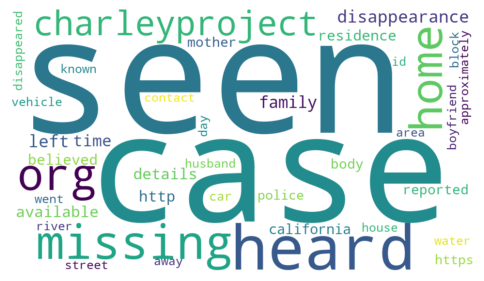

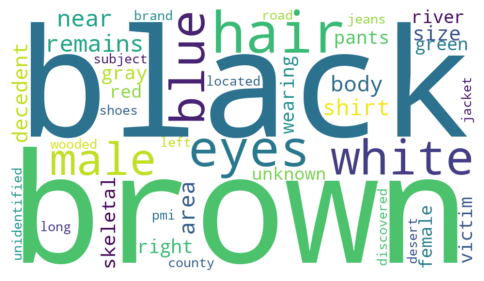

In [42]:
lda_text_model_f = LatentDirichletAllocation(n_components = 2, random_state=314)
W_text_matrix = lda_text_model_f.fit_transform(tfidf_text_vectors_f)
H_lda_text_matrix = lda_text_model_f.components_

wordcloud_topics(lda_text_model_f, tfidf_text_vectorizer_f.get_feature_names_out())

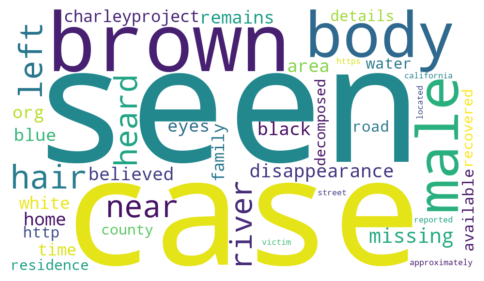

In [43]:
lda_text_model_w = LatentDirichletAllocation(n_components = 1, random_state=314)
W_text_matrix = lda_text_model_w.fit_transform(tfidf_text_vectors_w)
H_lda_text_matrix = lda_text_model_w.components_

wordcloud_topics(lda_text_model_w, tfidf_text_vectorizer_w.get_feature_names_out())

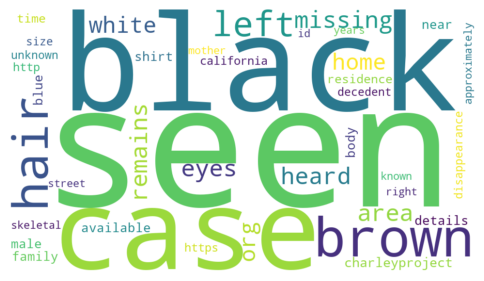

In [44]:
lda_text_model_nw = LatentDirichletAllocation(n_components = 1, random_state=314)
W_text_matrix = lda_text_model_nw.fit_transform(tfidf_text_vectors_nw)
H_lda_text_matrix = lda_text_model_nw.components_

wordcloud_topics(lda_text_model_nw, tfidf_text_vectorizer_nw.get_feature_names_out())

## Unsupervised Machine Learning: KMeans

In [63]:
tfidf = TfidfVectorizer(min_df = 5, ngram_range=(1,2), stop_words='english')
tfidf_no_na= tfidf.fit_transform(full_no_na['description'])

kmeans_text = KMeans(n_clusters = 4, random_state=504)

kmeans_text.fit(tfidf_no_na)
text_cluster_ids = kmeans_text.labels_
text_ids = pd.DataFrame(text_cluster_ids, columns=['text_id'])
text_ids.index = full_no_na.index

In [68]:
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(full_no_na[['age_low', 'age_high']]),columns = ['age_low', 'age_high'])
scaled.index = full_no_na.index

kmeans_data = pd.concat([full_no_na[['is_white', 'race_cat_count', 'long', 'lat']], scaled], axis = 1)

kmeans_data = kmeans_data.dropna()

kmeans_no_text = KMeans(n_clusters = 4, random_state=504)
kmeans_no_text.fit(kmeans_data)
no_text_cluster_ids = kmeans_no_text.labels_
no_text_ids = pd.DataFrame(no_text_cluster_ids, columns=['no_text_id'])
no_text_ids.index=full_no_na.index

In [69]:
ids = pd.concat([full_no_na, text_ids, no_text_ids], axis = 1)

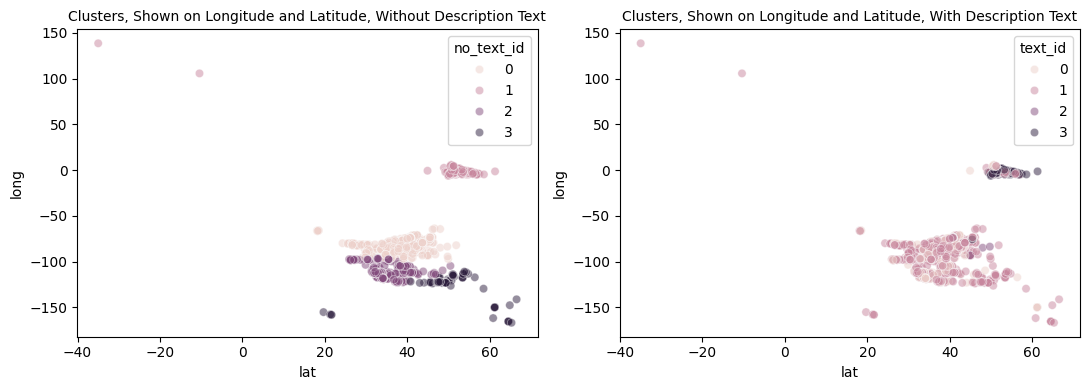

In [86]:
figs, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11,4))

sns.scatterplot(data = ids, x = 'lat', y = 'long', alpha= 0.5, hue = 'no_text_id', ax = axes[0])
axes[0].set_title("Clusters, Shown on Longitude and Latitude, Without Description Text", fontsize = 10)

sns.scatterplot(data = ids, x = 'lat', y = 'long', alpha= 0.5, hue = 'text_id', ax = axes[1])
axes[1].set_title("Clusters, Shown on Longitude and Latitude, With Description Text", fontsize = 10)

plt.tight_layout()
plt.show()

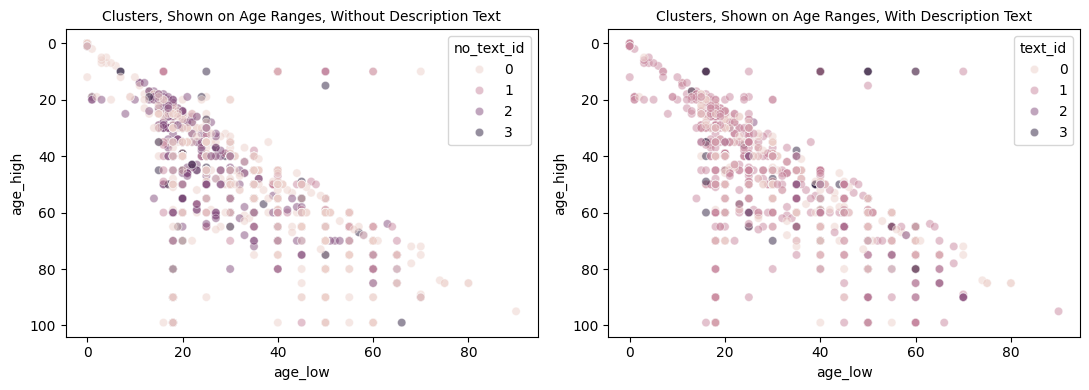

In [90]:
figs, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11,4))

sns.scatterplot(data = ids, x = 'age_low', y = 'age_high', alpha= 0.5, hue = 'no_text_id', ax = axes[0])
axes[0].set_title("Clusters, Shown on Age Ranges, Without Description Text", fontsize = 10)

sns.scatterplot(data = ids, x = 'age_low', y = 'age_high', alpha= 0.5, hue = 'text_id', ax = axes[1])
axes[1].set_title("Clusters, Shown on Age Ranges, With Description Text", fontsize = 10)

plt.tight_layout()
plt.show()


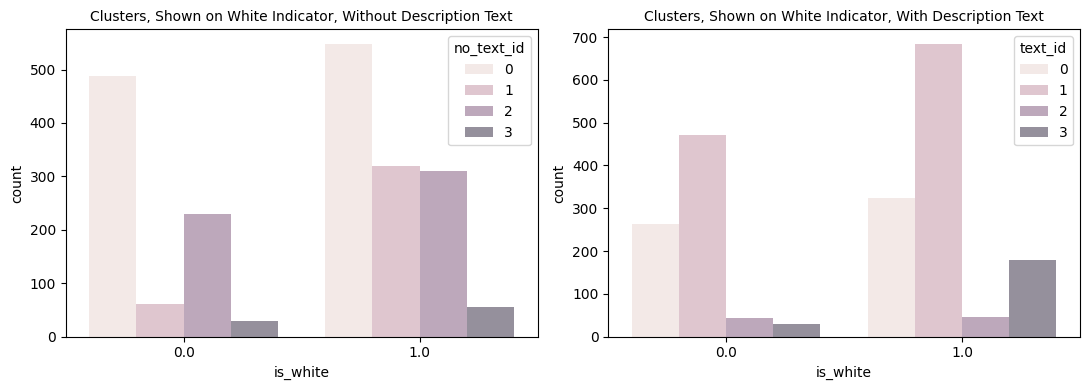

In [96]:
figs, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11,4))

sns.countplot(data = ids, x = 'is_white', alpha= 0.5, hue = 'no_text_id', ax = axes[0])
axes[0].set_title("Clusters, Shown on White Indicator, Without Description Text", fontsize = 10)

sns.countplot(data = ids, x = 'is_white', alpha= 0.5, hue = 'text_id', ax = axes[1])
axes[1].set_title("Clusters, Shown on White Indicator, With Description Text", fontsize = 10)

plt.tight_layout()
plt.show()


In [119]:
text_white_prop = pd.crosstab(index = ids['is_white'].replace(0, "not white").replace(1, "white"), columns = ids['text_id'], normalize='columns')
no_text_white_prop = pd.crosstab(index = ids['is_white'].replace(0, "not white").replace(1, "white"), columns = ids['no_text_id'], normalize='columns')

print(text_white_prop)
print(no_text_white_prop)

text_id          0         1         2         3
is_white                                        
not white  0.44898  0.408304  0.488636  0.138756
white      0.55102  0.591696  0.511364  0.861244
no_text_id         0         1         2         3
is_white                                          
not white   0.471042  0.160526  0.425139  0.345238
white       0.528958  0.839474  0.574861  0.654762


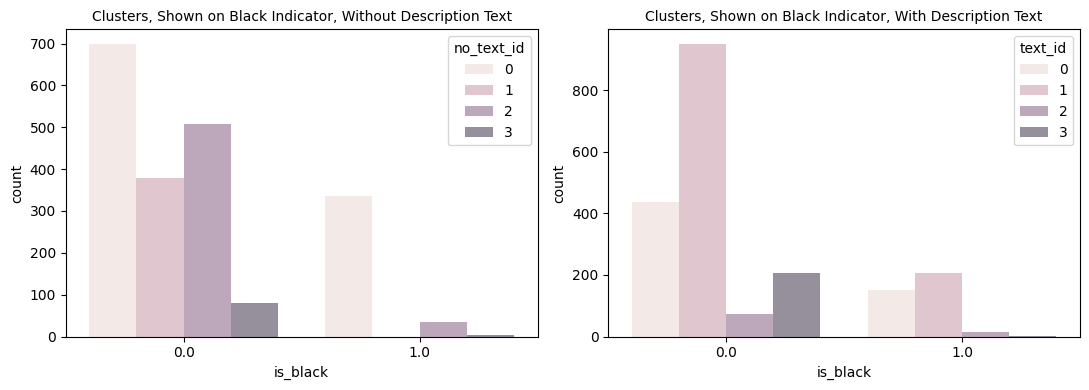

In [97]:
figs, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11,4))

sns.countplot(data = ids, x = 'is_black', alpha= 0.5, hue = 'no_text_id', ax = axes[0])
axes[0].set_title("Clusters, Shown on Black Indicator, Without Description Text", fontsize = 10)

sns.countplot(data = ids, x = 'is_black', alpha= 0.5, hue = 'text_id', ax = axes[1])
axes[1].set_title("Clusters, Shown on Black Indicator, With Description Text", fontsize = 10)

plt.tight_layout()
plt.show()


In [120]:
text_black_prop = pd.crosstab(index = ids['is_black'].replace(0, "not black").replace(1, "black"), columns = ids['text_id'], normalize='columns')
no_text_black_prop = pd.crosstab(index = ids['is_black'].replace(0, "not black").replace(1, "black"), columns = ids['no_text_id'], normalize='columns')

text_black_prop


text_id,0,1,2,3
is_black,,,,
black,0.256803,0.178201,0.170455,0.014354
not black,0.743197,0.821799,0.829545,0.985646


In [121]:
no_text_black_prop

no_text_id,0,1,2,3
is_black,,,,
black,0.32529,0.0,0.062847,0.047619
not black,0.67471,1.0,0.937153,0.952381


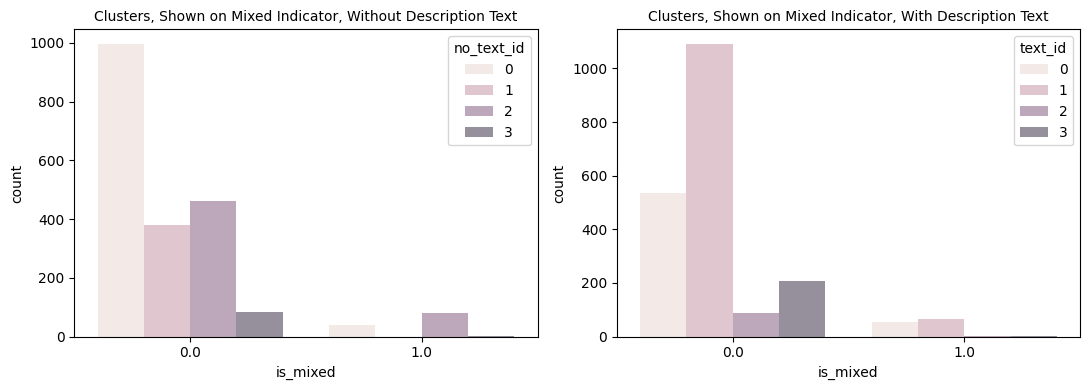

In [98]:
figs, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11,4))

sns.countplot(data = ids, x = 'is_mixed', alpha= 0.5, hue = 'no_text_id', ax = axes[0])
axes[0].set_title("Clusters, Shown on Mixed Indicator, Without Description Text", fontsize = 10)

sns.countplot(data = ids, x = 'is_mixed', alpha= 0.5, hue = 'text_id', ax = axes[1])
axes[1].set_title("Clusters, Shown on Mixed Indicator, With Description Text", fontsize = 10)

plt.tight_layout()
plt.show()

In [122]:
text_mix_prop = pd.crosstab(index = ids['is_mixed'].replace(0, "not mixed").replace(1, "mixed"), columns = ids['text_id'], normalize='columns')
no_text_mix_prop = pd.crosstab(index = ids['is_mixed'].replace(0, "not mixed").replace(1, "mixed"), columns = ids['no_text_id'], normalize='columns')

text_mix_prop

text_id,0,1,2,3
is_mixed,,,,
mixed,0.090136,0.056228,0.011364,0.004785
not mixed,0.909864,0.943772,0.988636,0.995215


In [123]:
no_text_mix_prop

no_text_id,0,1,2,3
is_mixed,,,,
mixed,0.03861,0.0,0.146026,0.011905
not mixed,0.96139,1.0,0.853974,0.988095
